In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [3]:
y = np.random.randint(0,7,2100)
idx= []
for i in range(7):
    print(i,sum(y==i))
    idx.append(y==i)

0 286
1 330
2 282
3 296
4 330
5 288
6 288


In [4]:
x = np.zeros((2100,2))

In [5]:


x[idx[0],:] = np.random.uniform(low=[1.5,8],high=[2,7],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[1.5,5],high=[2,6],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[1.5,3],high=[2,4],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1.5,1],high=[2,2],size=(sum(idx[3]),2))

x[idx[4],:] = np.random.uniform(low=[1.5,-1],high=[2,0],size=(sum(idx[4]),2))

x[idx[5],:] = np.random.uniform(low=[1.5,-2],high=[2,-3],size=(sum(idx[5]),2))


x[idx[6],:] = np.random.uniform(low=[2.1,-0.3],high=[2.2,-0.2],size=(sum(idx[6]),2))


#x[idx[7],:] = np.random.uniform(low=[2.5,1],high=[3.5,4],size=(sum(idx[7]),2))

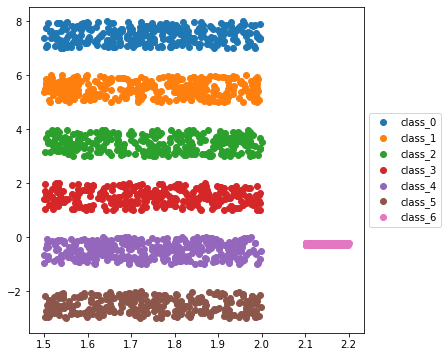

In [6]:
fig = plt.figure(figsize=(6,6))
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_4.png",bbox_inches="tight")
plt.savefig("dist_4.pdf",bbox_inches="tight")


In [7]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [8]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9) #m=2
    a = []
    np.random.seed(i+j)
    for i in range(9):  #m=2
        if i == fg_idx: 
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(18,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)
mosaic_list = np.concatenate(mosaic_list,axis=1).T

In [9]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [10]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(2,1)
        #self.linear2 = nn.Linear(100,200)
        #self.linear3 = nn.Linear(200,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=9
          x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [11]:
#torch.manual_seed(1236)
where = Wherenet().double()
where = where
# out_where,alphas = where(input1)
# out_where.shape,alphas.shape

In [12]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,6)
        #self.linear2 = nn.Linear(5,10)
        #self.linear3 = nn.Linear(10,15)
        #self.linear4 = nn.Linear(15,20)
        #self.linear5 = nn.Linear(20,25)
        #self.linear6 = nn.Linear(25,6)
    
    def forward(self,x):
      #x = F.relu(self.linear1(x))
      #x = F.relu(self.linear2(x))
      #x = F.relu(self.linear3(x))
      #x = F.relu(self.linear4(x))
      #x = F.relu(self.linear5(x))
      x = self.linear1(x)
      return x

In [13]:
#torch.manual_seed(1236)
what = Whatnet().double()
# what(out_where)

In [14]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9)  #m=2
    a = []
    for i in range(9): #m=2
        np.random.seed(i+j+3000)
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(18,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T

In [15]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [16]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [17]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    avg_inp,alphas = where(inputs)
    outputs = what(avg_inp)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 30000 train images: 16 %
total correct 496
total train set images 3000
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 496 =============> FFPT : 16 %
focus_true_pred_false 980 =============> FTPF : 32 %
focus_false_pred_false 1524 =============> FFPF : 50 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  3000
3000


In [18]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    avg_inp,alphas = where(inputs)    
    outputs = what(avg_inp)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 10000 test images: 15 %
total correct 150
total train set images 1000
focus_true_pred_true 0 =============> FTPT : 0 %
focus_false_pred_true 150 =============> FFPT : 15 %
focus_true_pred_false 329 =============> FTPF : 32 %
focus_false_pred_false 521 =============> FFPF : 52 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [19]:
def plot_focus_classification_illustration(where_mdl,what_mdl,epoch,save_fig=False):
  xx,yy= np.meshgrid(np.arange(1.4,2.4,0.03),np.arange(-3.5,8.5,0.03))
  X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
  X = torch.Tensor(X).double()
  Y = where_mdl.helper(X)
  Y1 = what_mdl(X)
  X = X.detach().numpy()
  Y = Y[:,0].detach().numpy()
 
  #  focus illustration
  fig = plt.figure(figsize=(6,6))
  cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Y.reshape(xx.shape))
  plt.title(str(epoch))
  plt.xlabel("X1")
  plt.ylabel("X2")
  fig.colorbar(cs)
  for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  if save_fig==True:
    plt.savefig("dist_4_fc.png")#,bbox_inches='tight')
    plt.savefig("dist_4_fc.pdf")
  
  # classification illustration
  Y1 = Y1.detach().numpy()
  Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
  _,Z4= torch.max(Y1,1)
  Z1 = Y1[:,0]
  Z2 = Y1[:,1]


  # calculate average data
  avrg = []
  lbl = []
  with torch.no_grad():
    for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      avg_inp,alphas = where(inputs)
      avrg.append(avg_inp)
      lbl.append(labels.numpy())
  avrg= np.concatenate(avrg,axis=0)
  lbl = np.concatenate(lbl,axis=0)
  indices = []
  for i in range(6):
    #print(i,sum(lbl==i))
    indices.append(lbl==i)

  # plot decision boundary and averaged data
  plt.figure(figsize=(6,6))
  cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z4.reshape(xx.shape))
  for i in range(6):
    plt.scatter(avrg[indices[i],0],avrg[indices[i],1],label="class_"+str(i))
  plt.title(str(epoch))
  if save_fig == True:
    plt.savefig("dist_4_db.png",bbox_inches="tight")
    plt.savefig("dist_4_db.pdf",bbox_inches="tight")

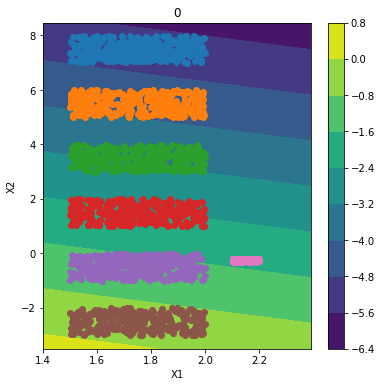

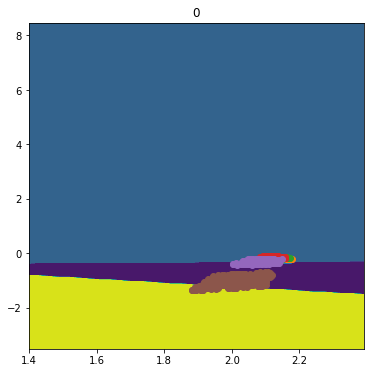

In [20]:
plot_focus_classification_illustration(where,what,epoch=0,save_fig=True)

[1,     6] loss: 1.861
[1,    12] loss: 1.818
[2,     6] loss: 1.765
[2,    12] loss: 1.755
[3,     6] loss: 1.730
[3,    12] loss: 1.723
[4,     6] loss: 1.706
[4,    12] loss: 1.684
[5,     6] loss: 1.674
[5,    12] loss: 1.637
[6,     6] loss: 1.621
[6,    12] loss: 1.601
[7,     6] loss: 1.583
[7,    12] loss: 1.554
[8,     6] loss: 1.525
[8,    12] loss: 1.541
[9,     6] loss: 1.511
[9,    12] loss: 1.497
[10,     6] loss: 1.485
[10,    12] loss: 1.480
[11,     6] loss: 1.466
[11,    12] loss: 1.463
[12,     6] loss: 1.455
[12,    12] loss: 1.446
[13,     6] loss: 1.463
[13,    12] loss: 1.416
[14,     6] loss: 1.439
[14,    12] loss: 1.421
[15,     6] loss: 1.422
[15,    12] loss: 1.423
[16,     6] loss: 1.408
[16,    12] loss: 1.424
[17,     6] loss: 1.406
[17,    12] loss: 1.414
[18,     6] loss: 1.408
[18,    12] loss: 1.402
[19,     6] loss: 1.409
[19,    12] loss: 1.394
[20,     6] loss: 1.398
[20,    12] loss: 1.397
[21,     6] loss: 1.391
[21,    12] loss: 1.397
[22,     6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[111,     6] loss: 1.346
[111,    12] loss: 1.316
[112,     6] loss: 1.324
[112,    12] loss: 1.336
[113,     6] loss: 1.330
[113,    12] loss: 1.330
[114,     6] loss: 1.340
[114,    12] loss: 1.320
[115,     6] loss: 1.341
[115,    12] loss: 1.319
[116,     6] loss: 1.323
[116,    12] loss: 1.335
[117,     6] loss: 1.334
[117,    12] loss: 1.323
[118,     6] loss: 1.314
[118,    12] loss: 1.343
[119,     6] loss: 1.344
[119,    12] loss: 1.312
[120,     6] loss: 1.328
[120,    12] loss: 1.327
[121,     6] loss: 1.336
[121,    12] loss: 1.318
[122,     6] loss: 1.331
[122,    12] loss: 1.322
[123,     6] loss: 1.342
[123,    12] loss: 1.310
[124,     6] loss: 1.330
[124,    12] loss: 1.322
[125,     6] loss: 1.327
[125,    12] loss: 1.323
[126,     6] loss: 1.314
[126,    12] loss: 1.336
[127,     6] loss: 1.312
[127,    12] loss: 1.338
[128,     6] loss: 1.332
[128,    12] loss: 1.317
[129,     6] loss: 1.343
[129,    12] loss: 1.306
[130,     6] loss: 1.314
[130,    12] loss: 1.333


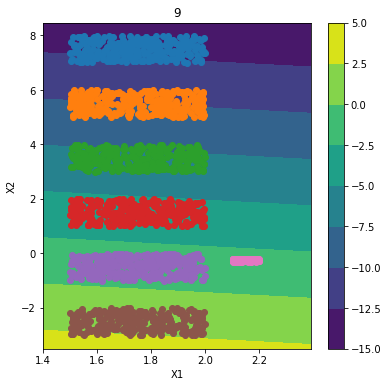

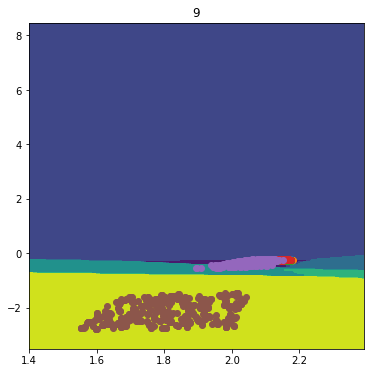

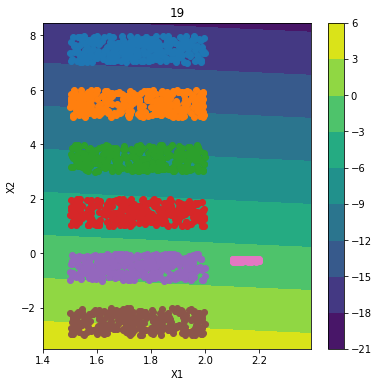

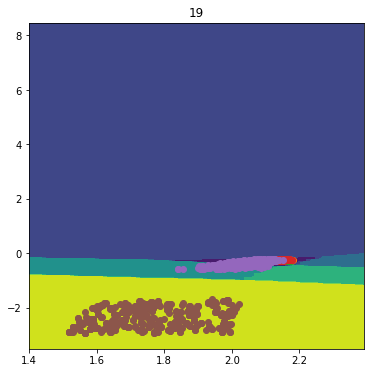

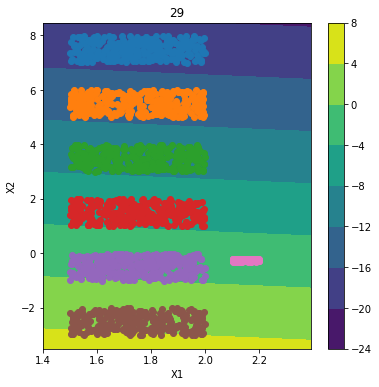

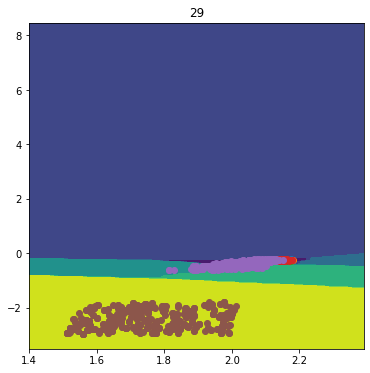

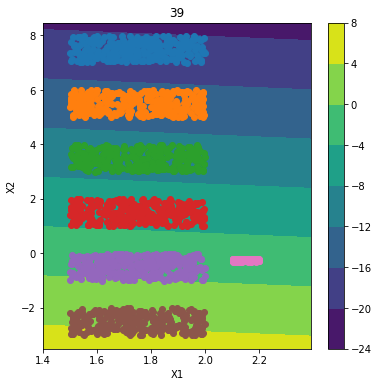

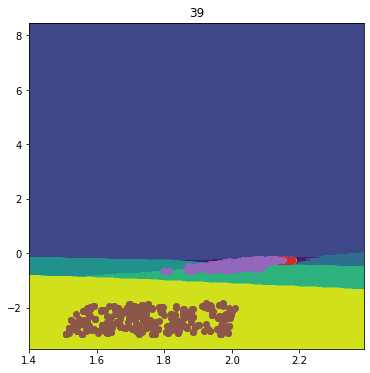

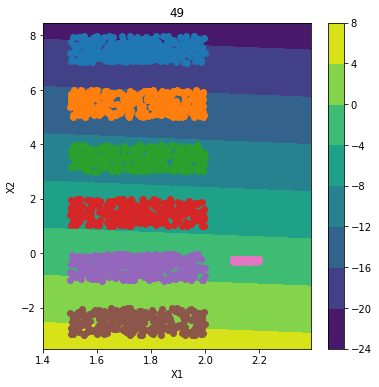

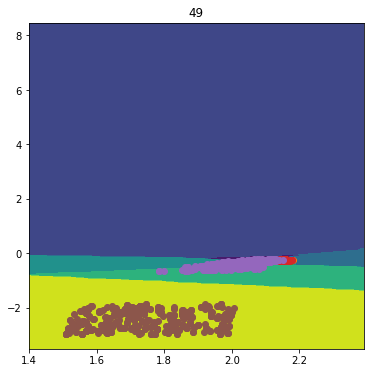

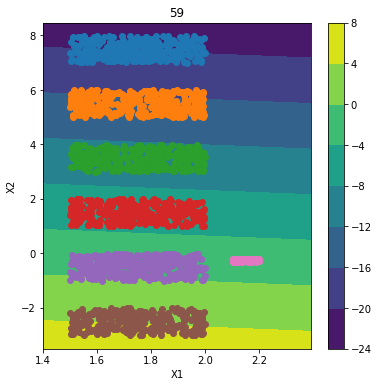

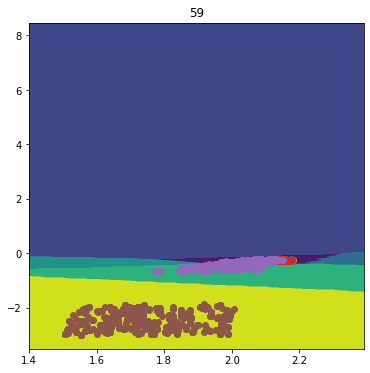

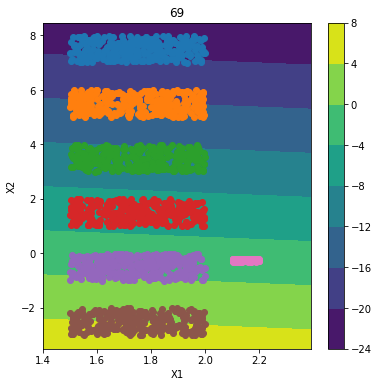

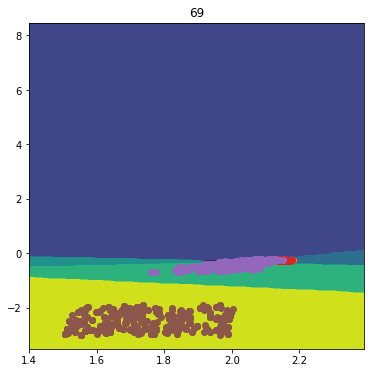

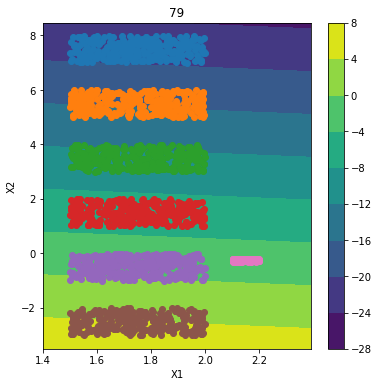

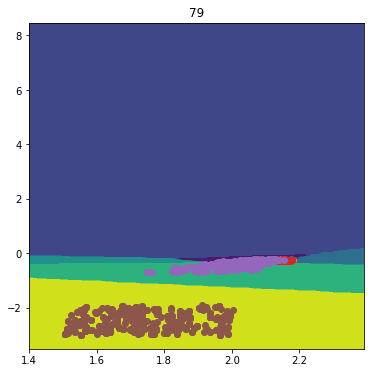

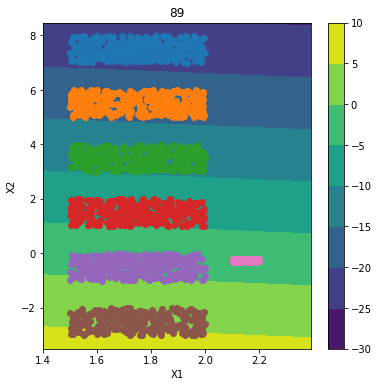

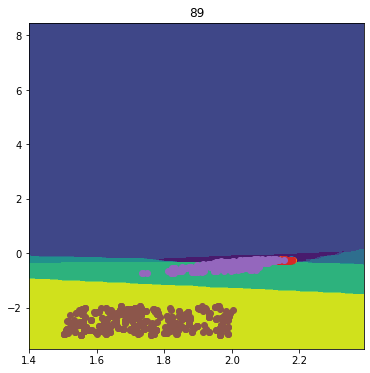

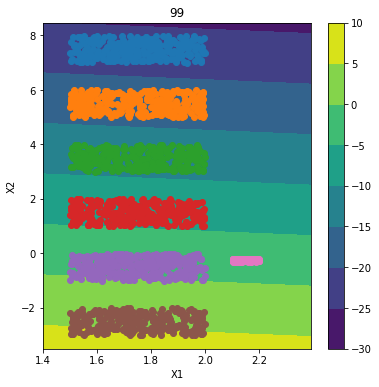

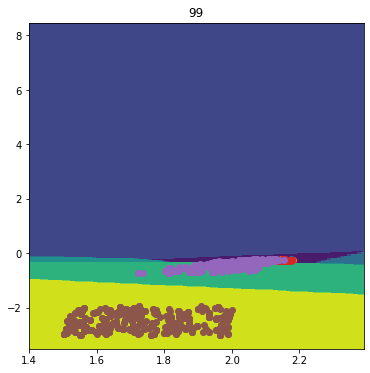

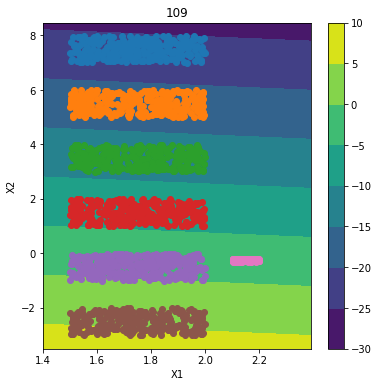

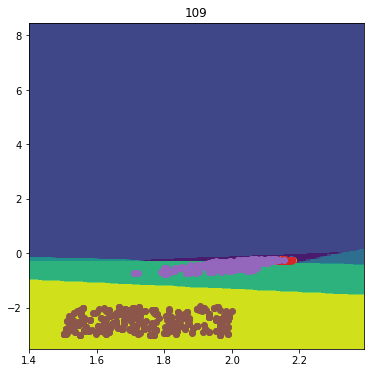

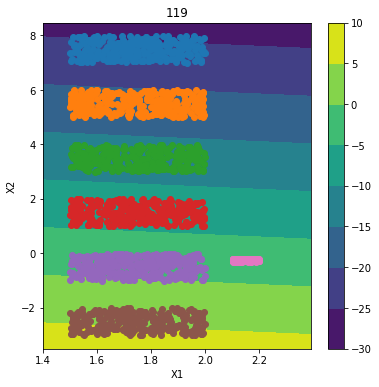

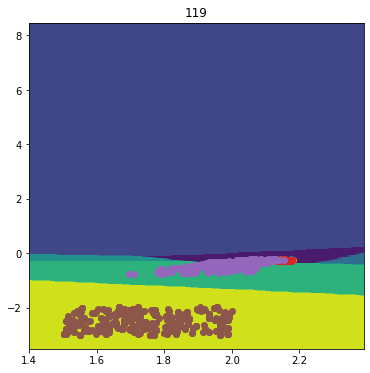

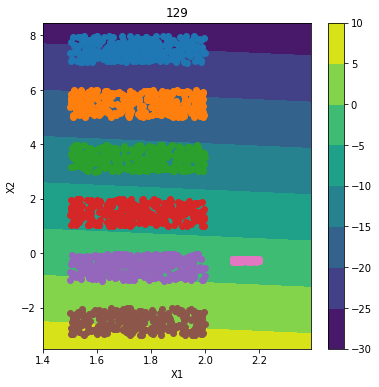

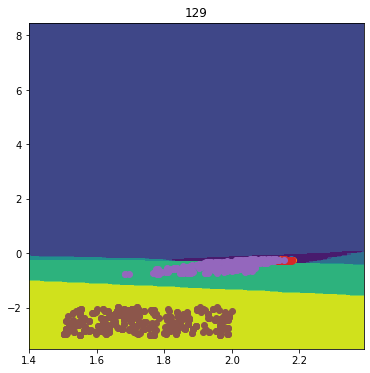

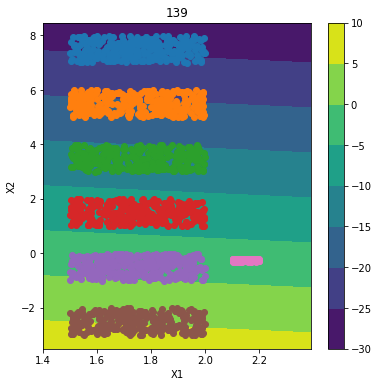

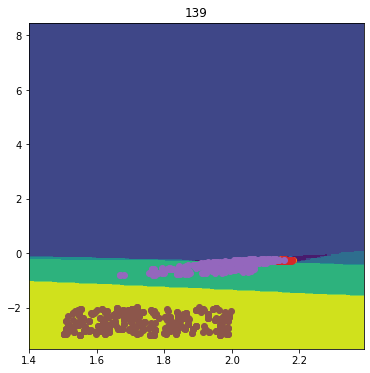

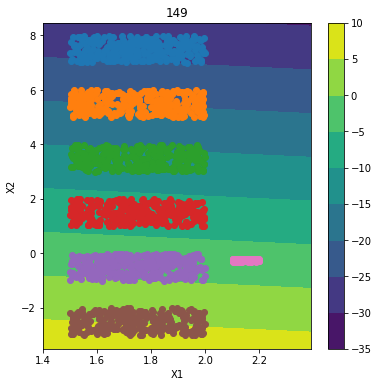

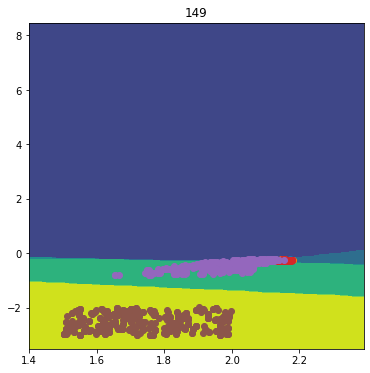

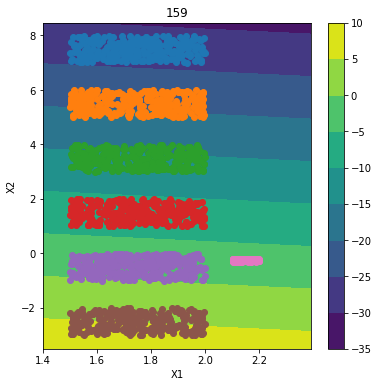

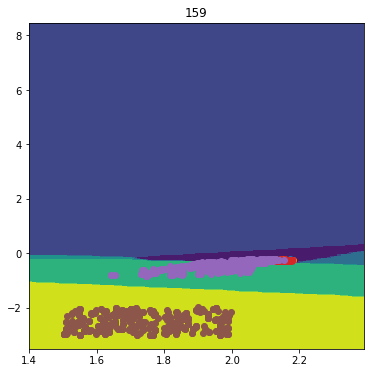

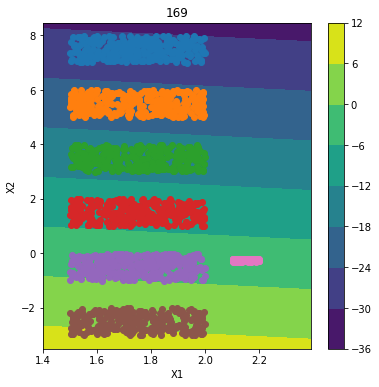

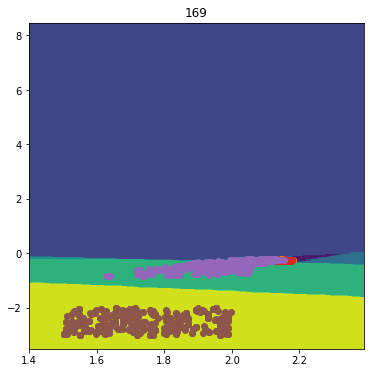

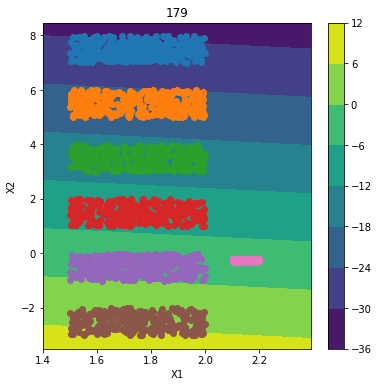

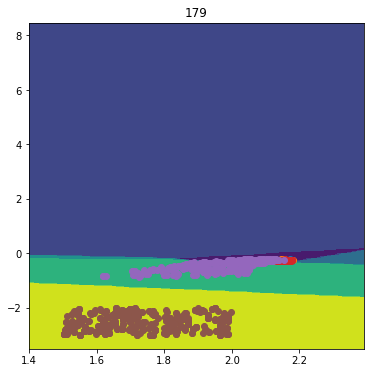

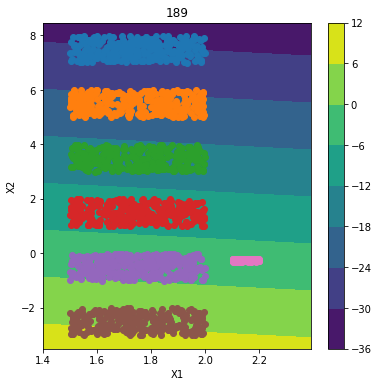

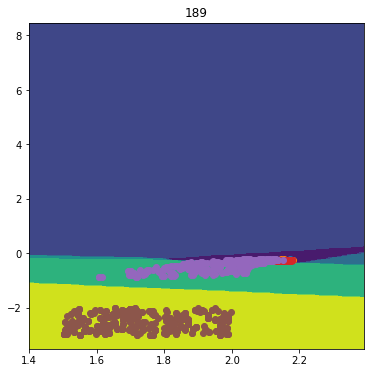

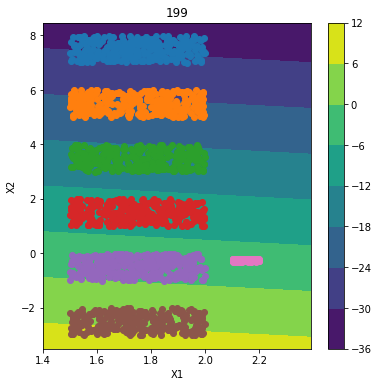

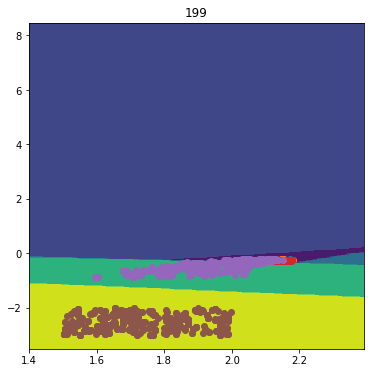

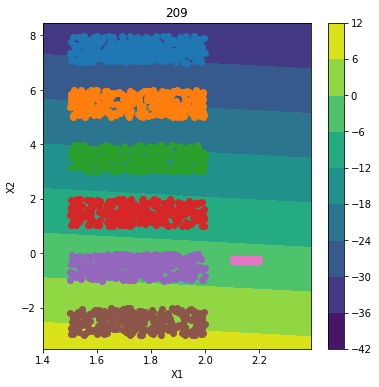

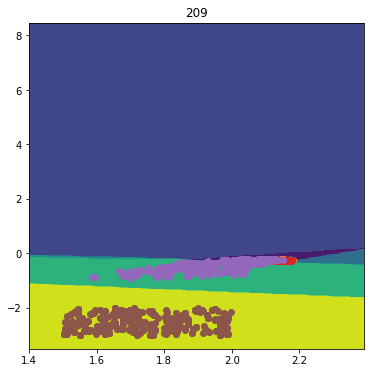

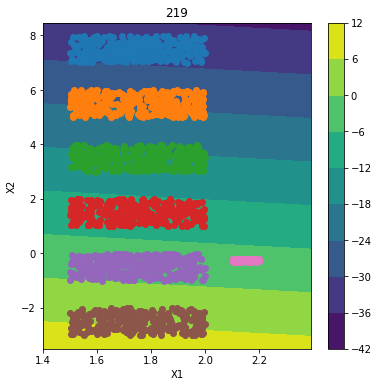

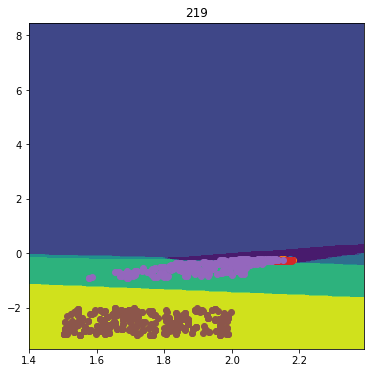

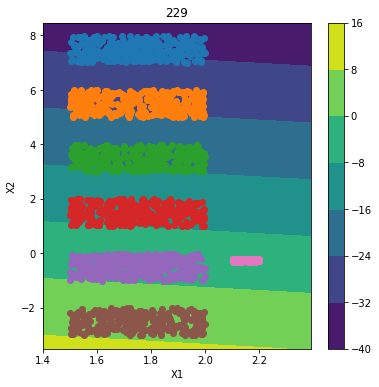

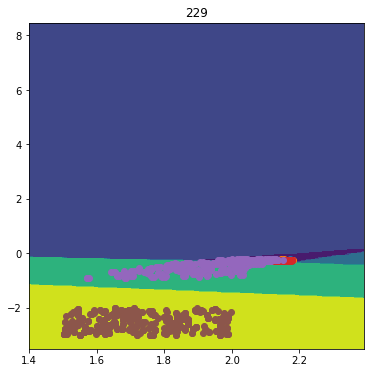

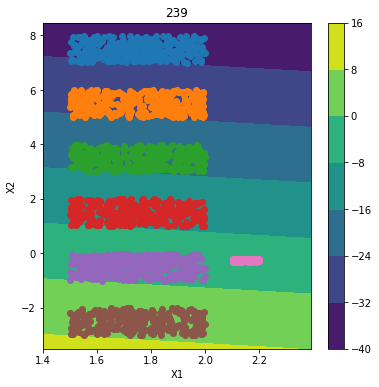

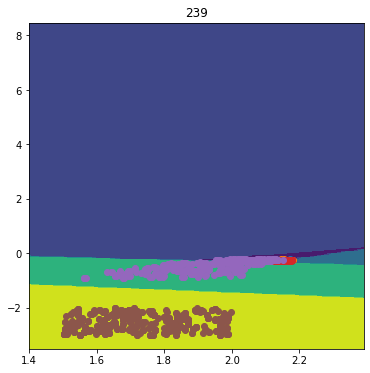

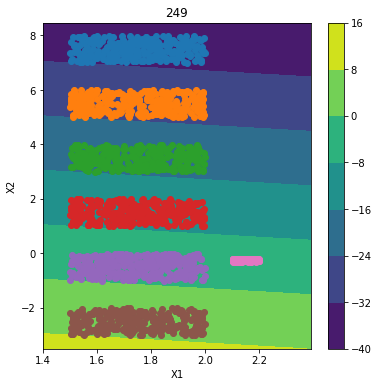

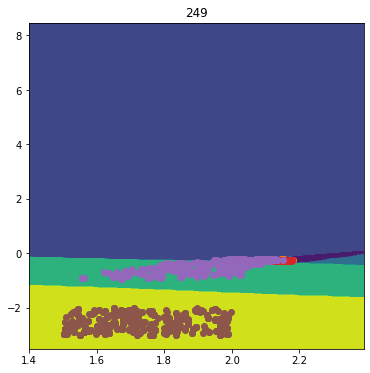

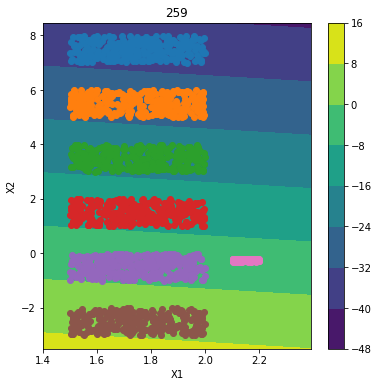

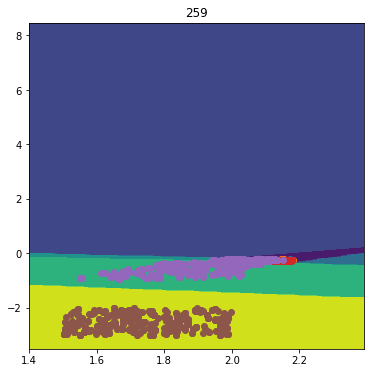

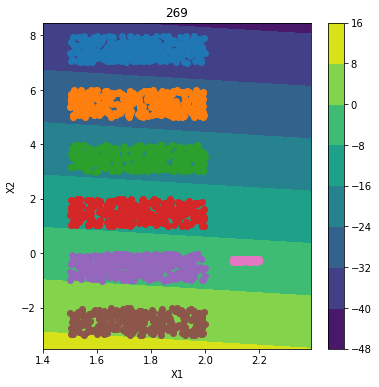

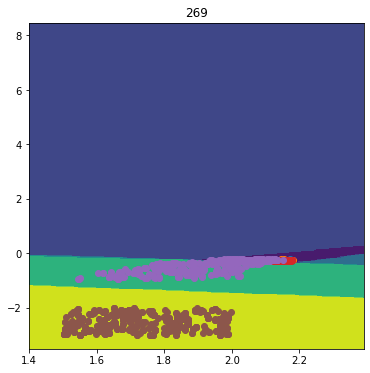

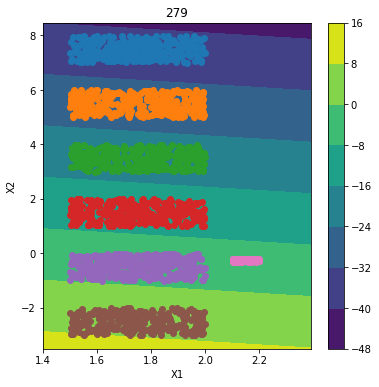

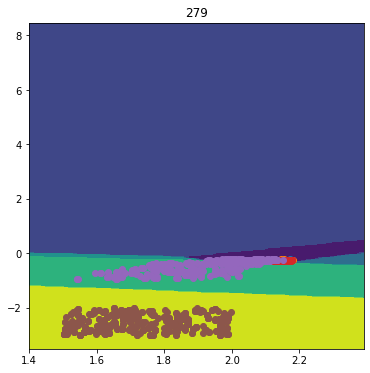

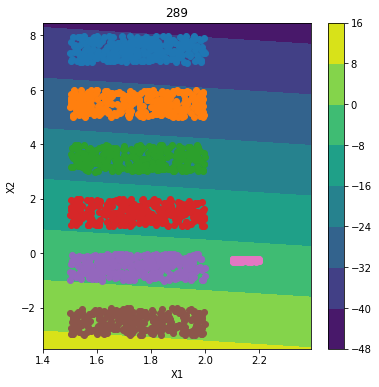

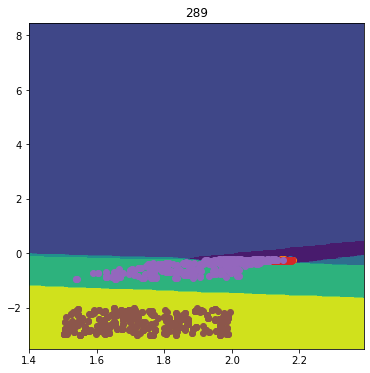

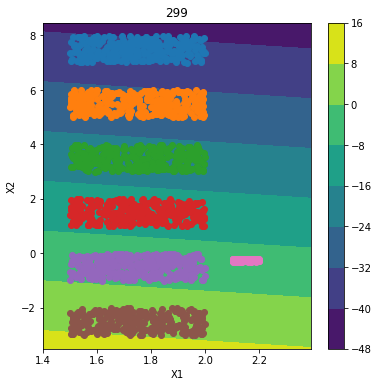

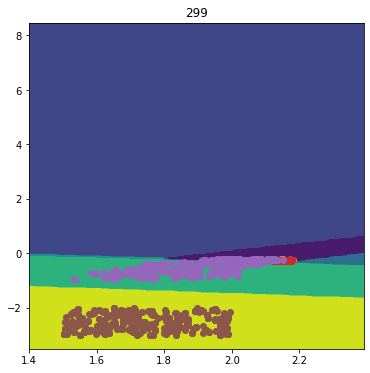

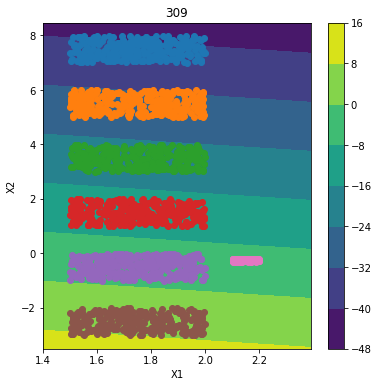

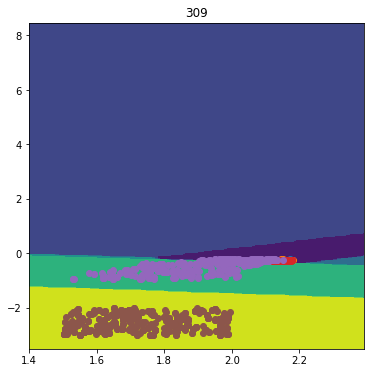

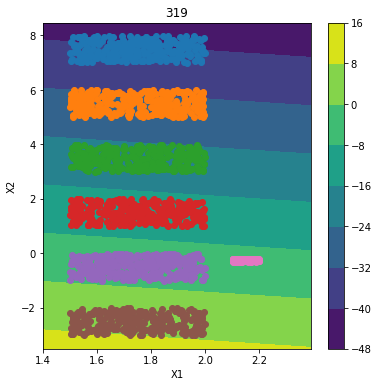

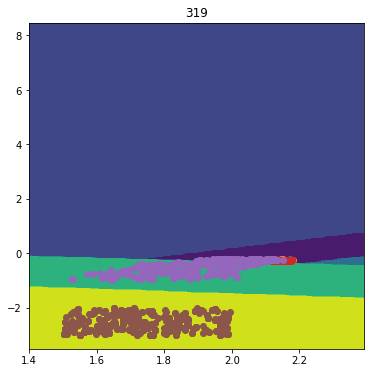

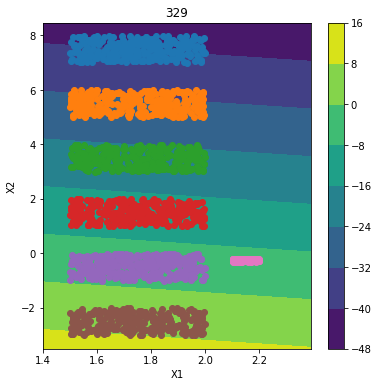

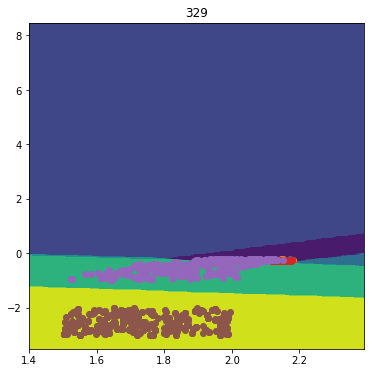

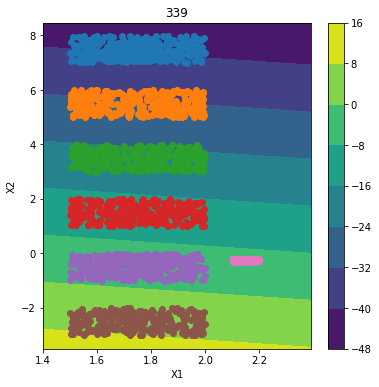

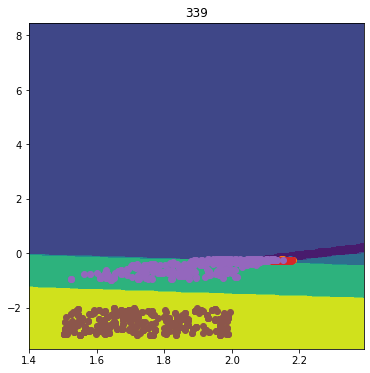

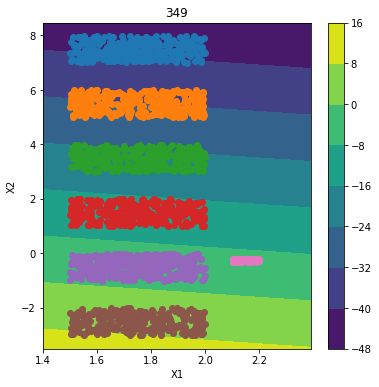

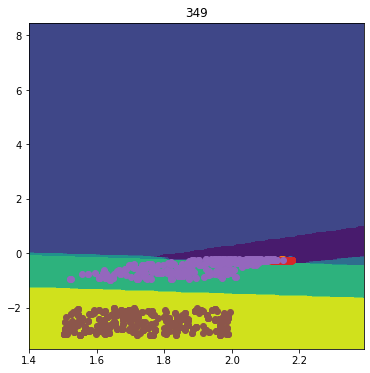

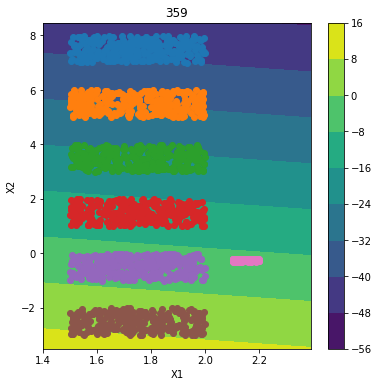

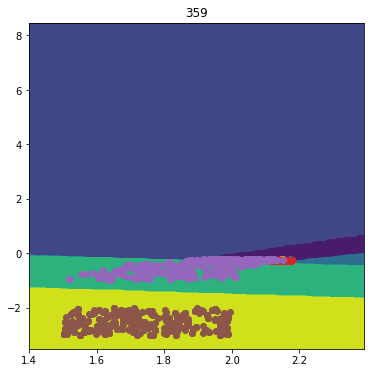

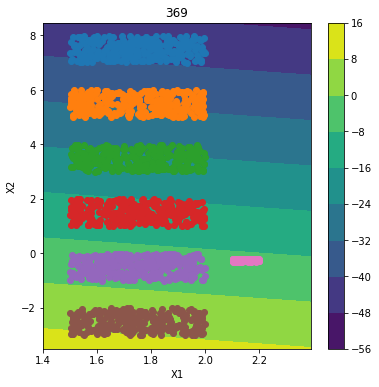

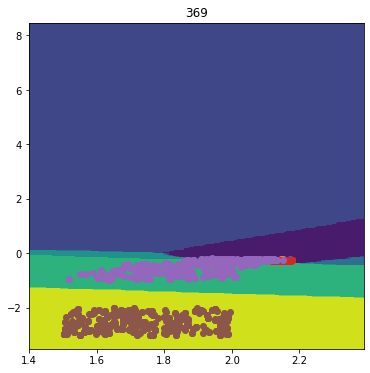

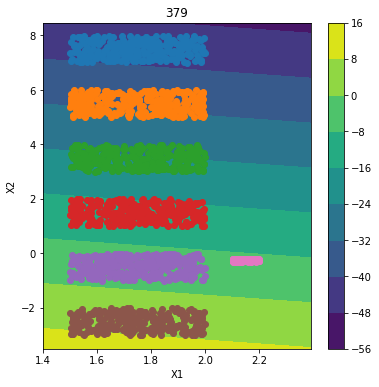

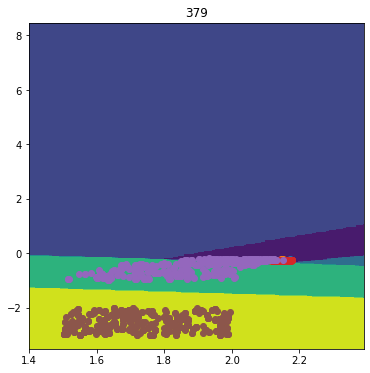

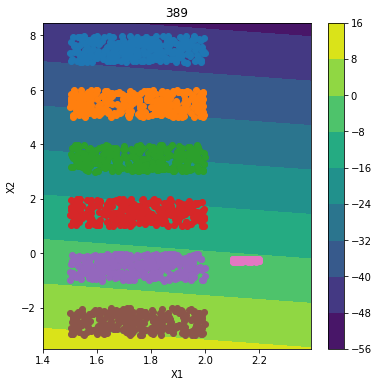

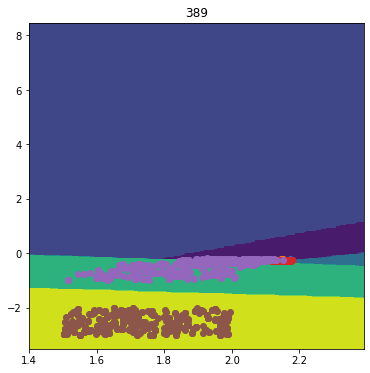

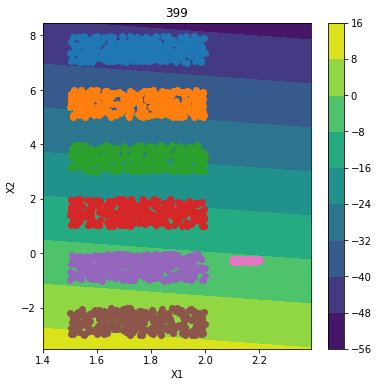

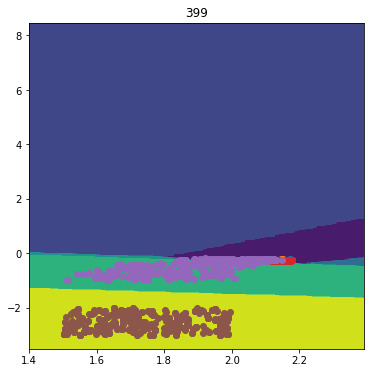

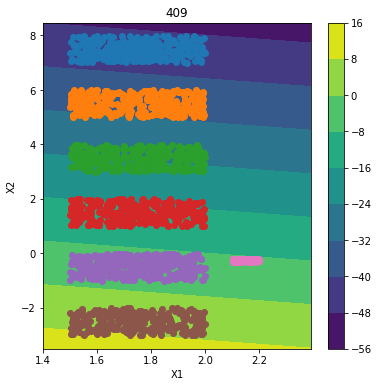

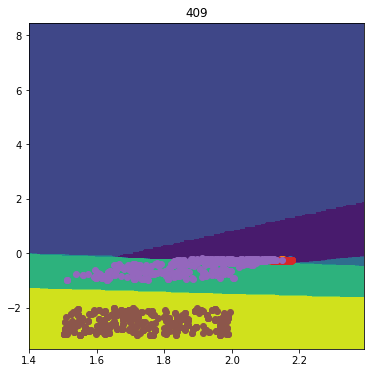

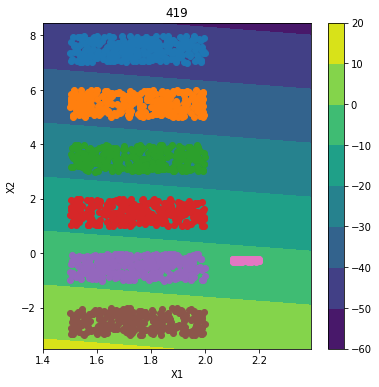

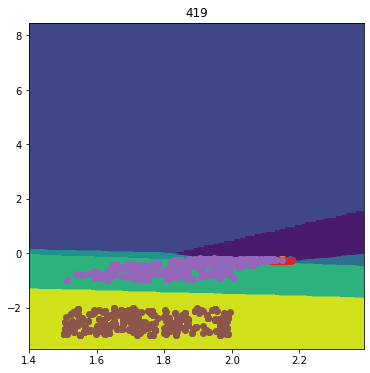

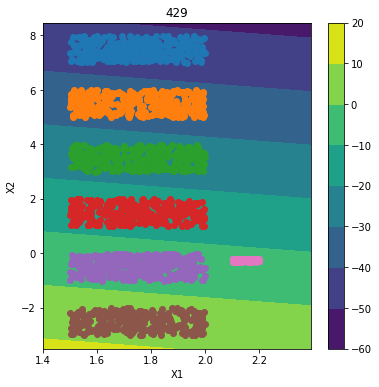

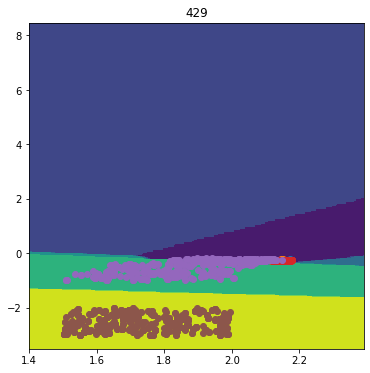

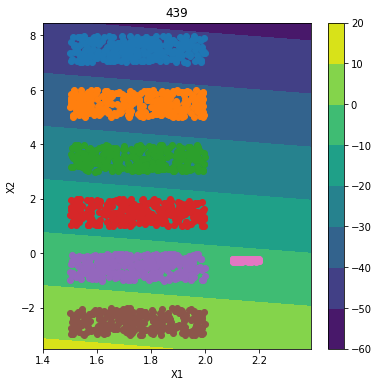

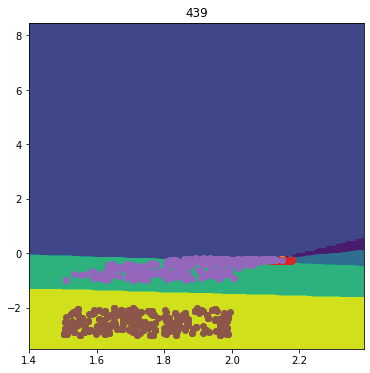

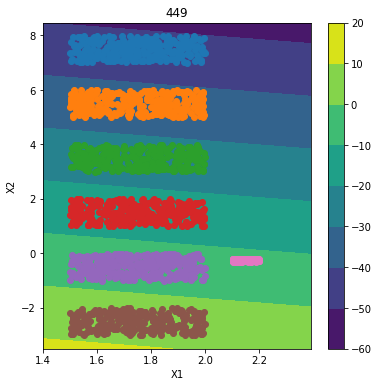

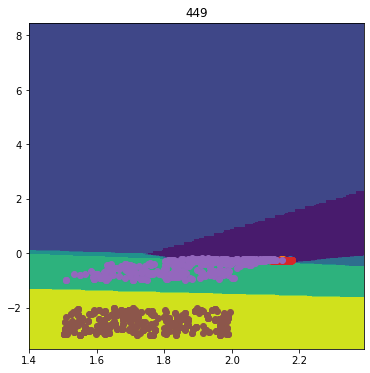

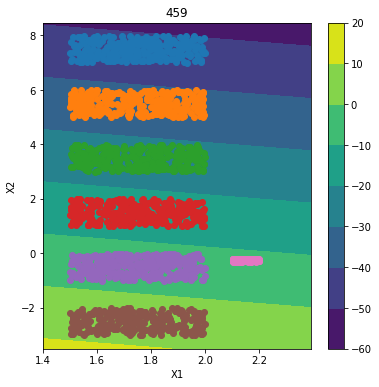

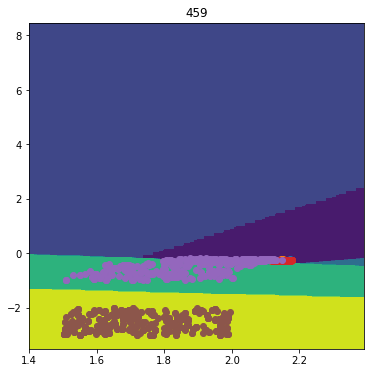

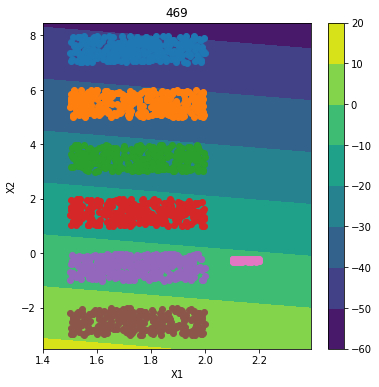

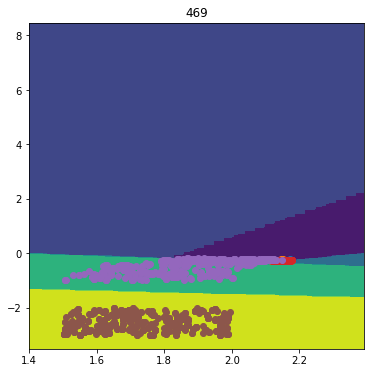

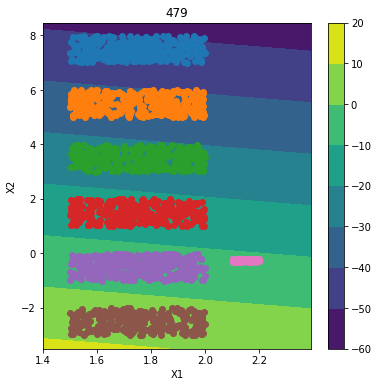

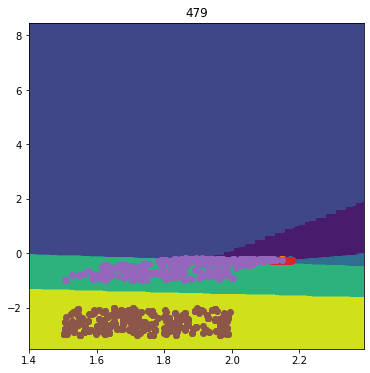

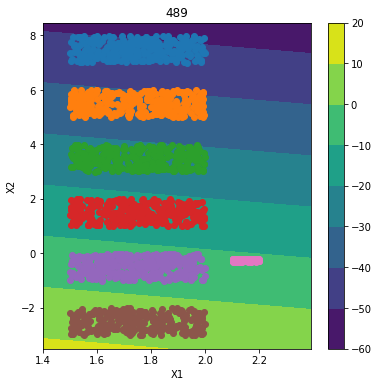

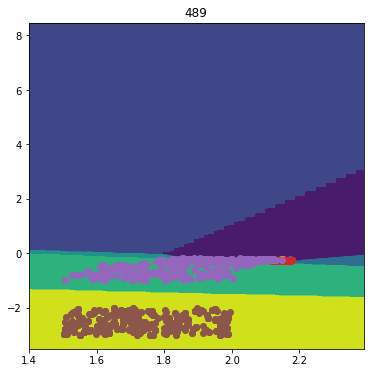

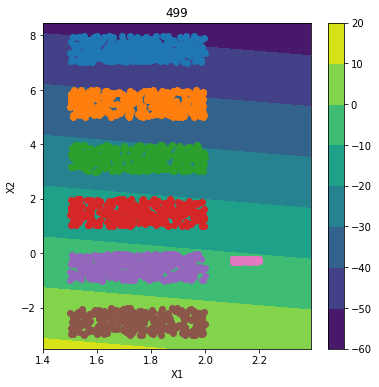

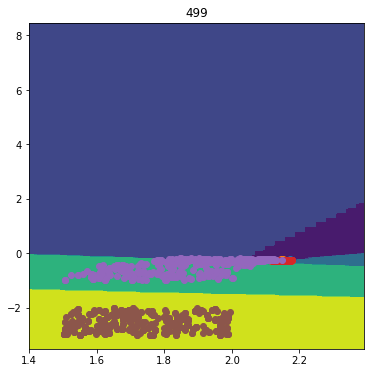

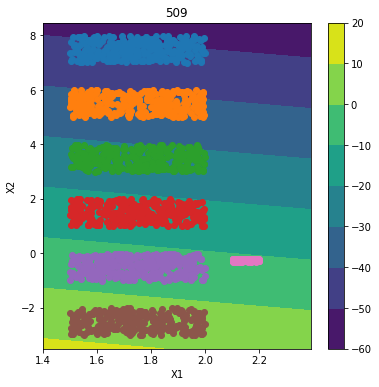

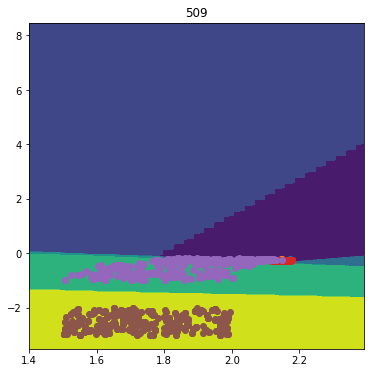

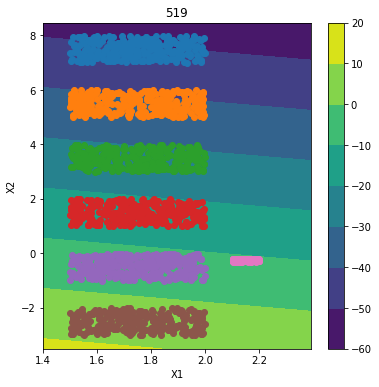

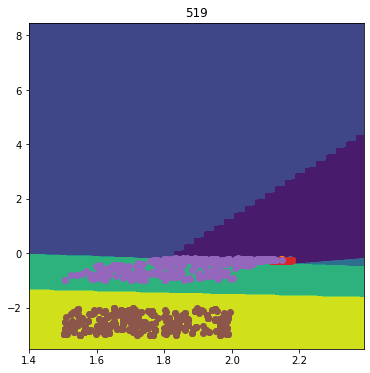

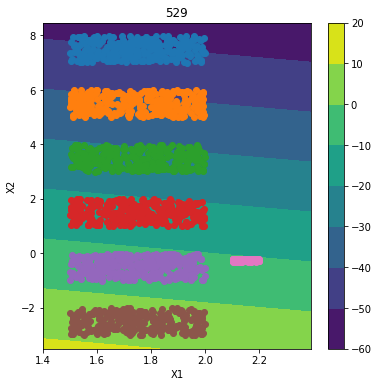

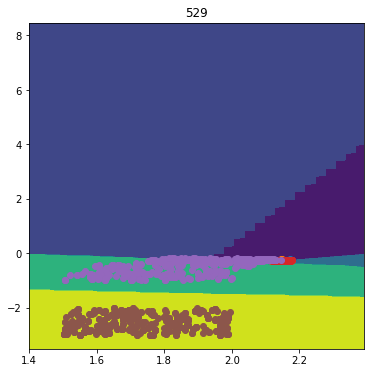

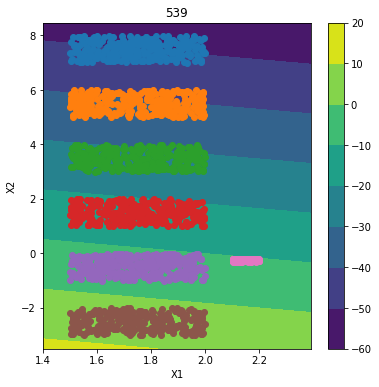

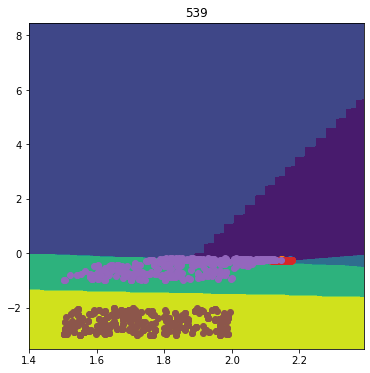

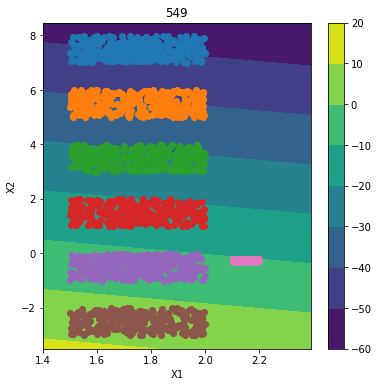

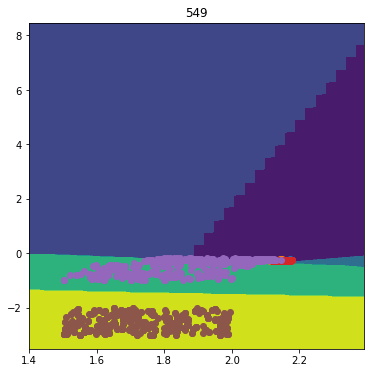

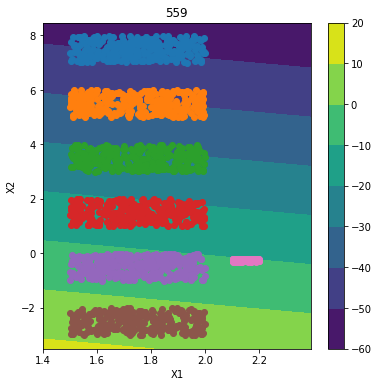

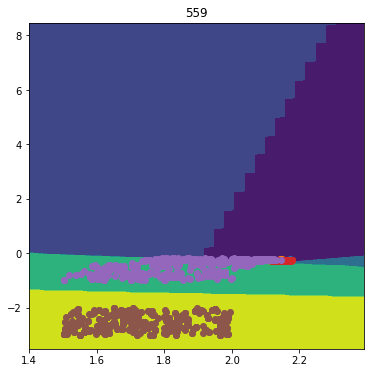

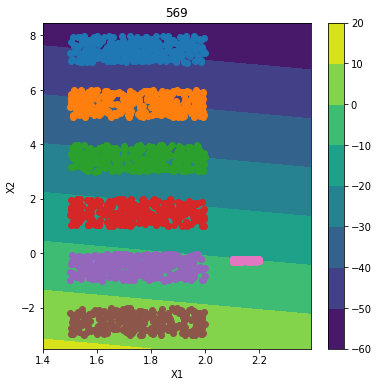

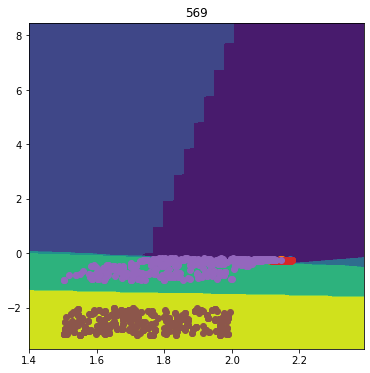

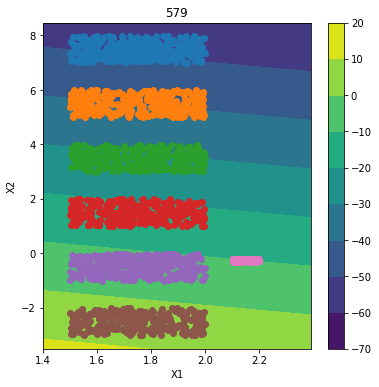

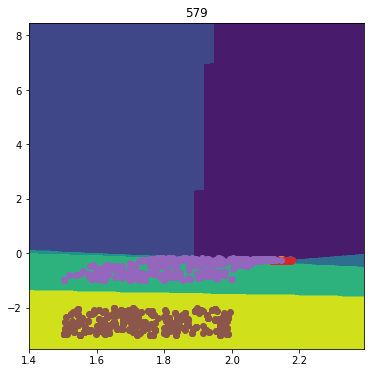

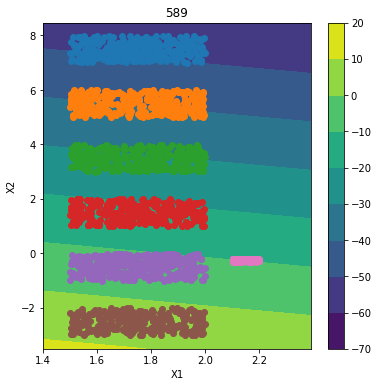

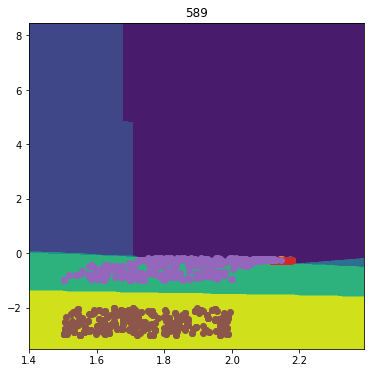

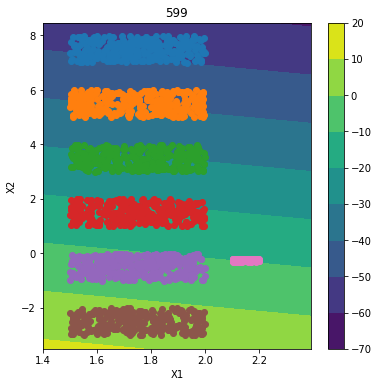

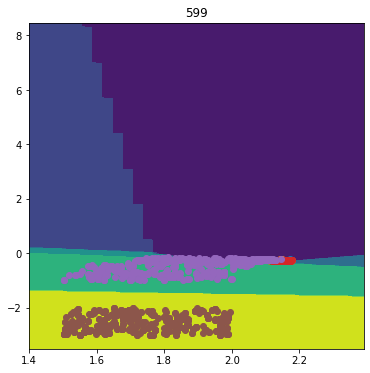

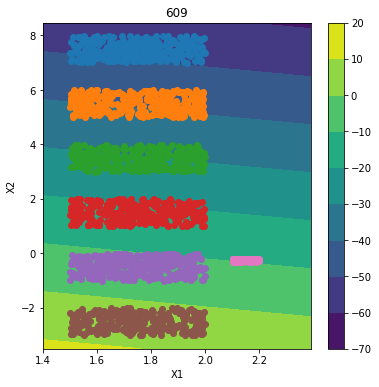

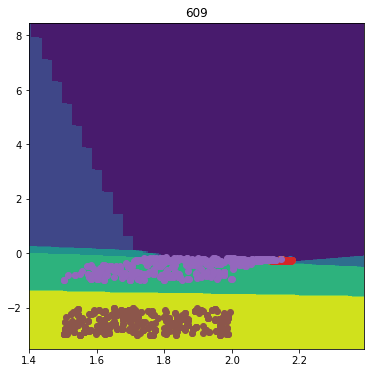

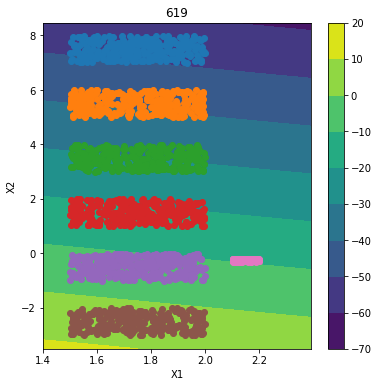

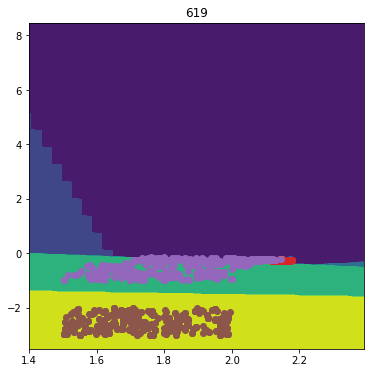

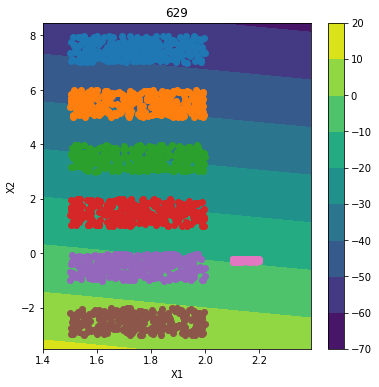

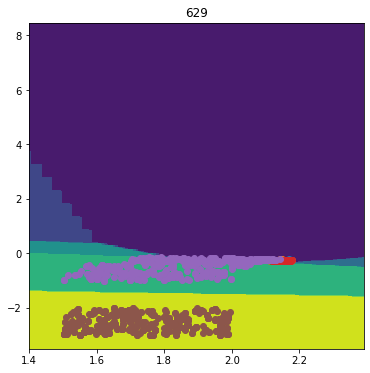

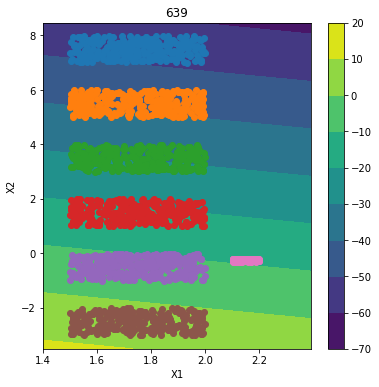

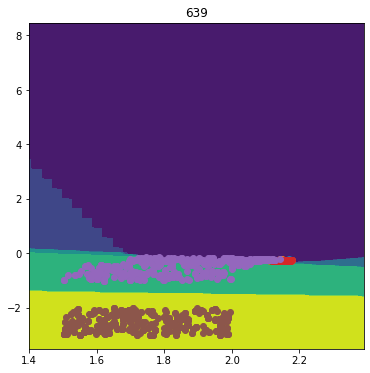

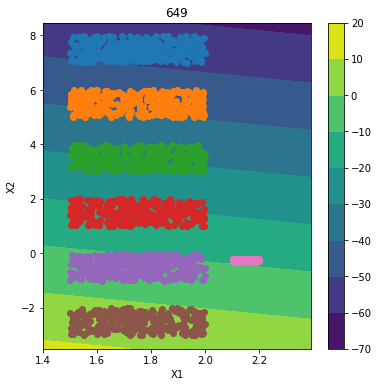

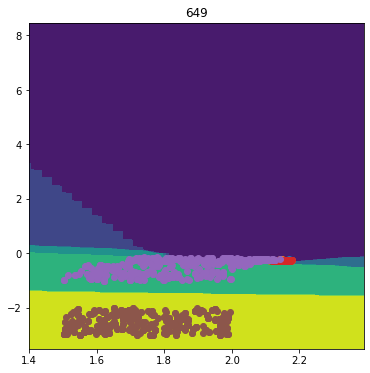

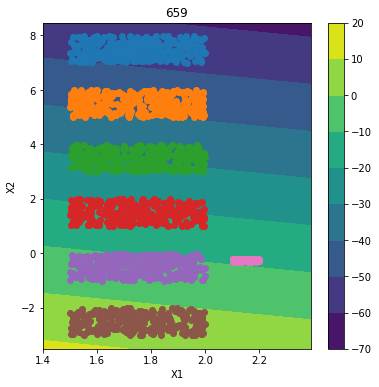

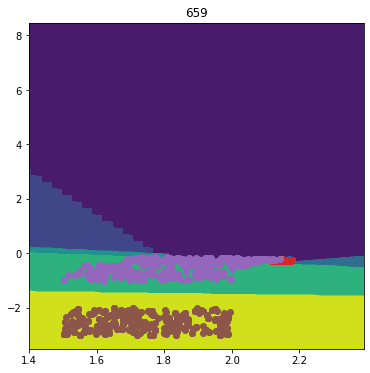

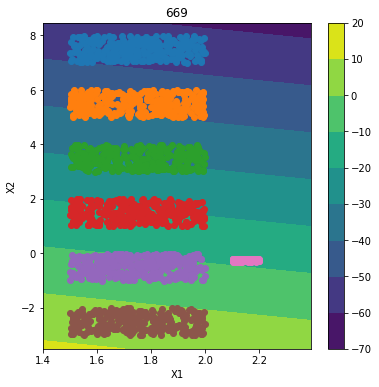

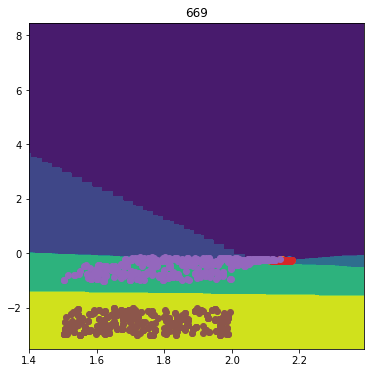

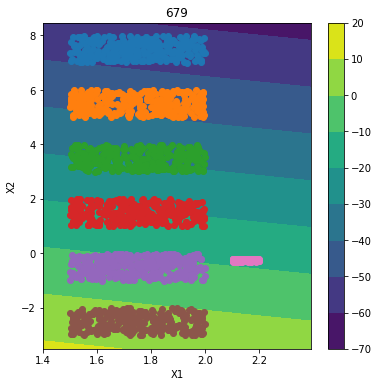

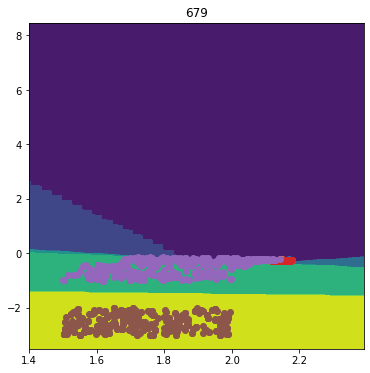

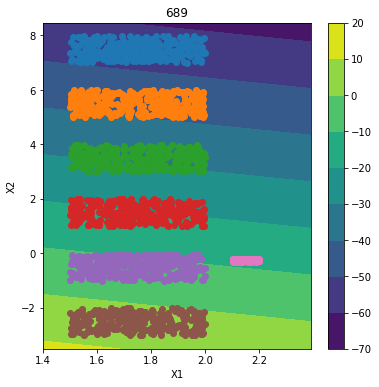

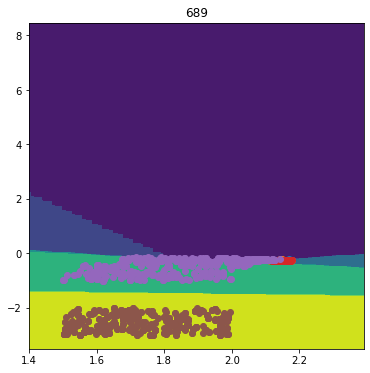

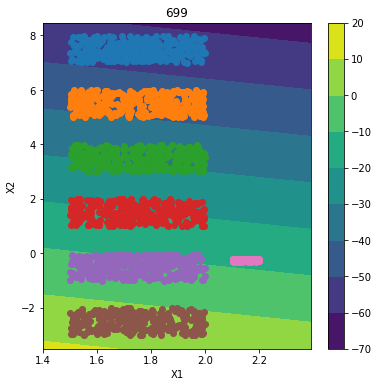

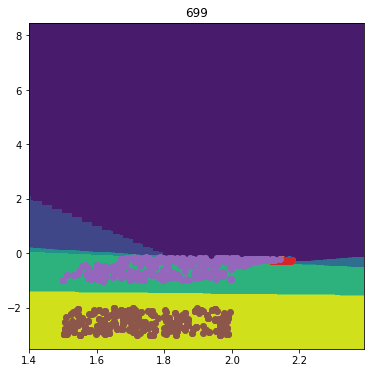

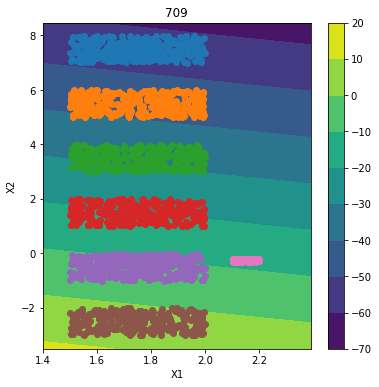

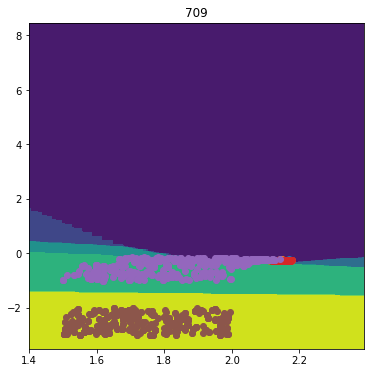

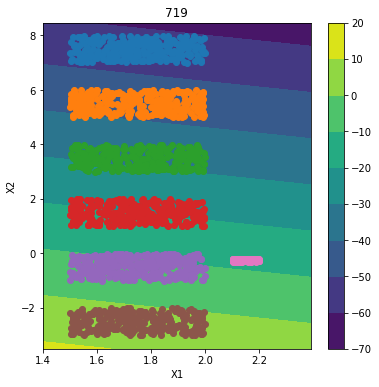

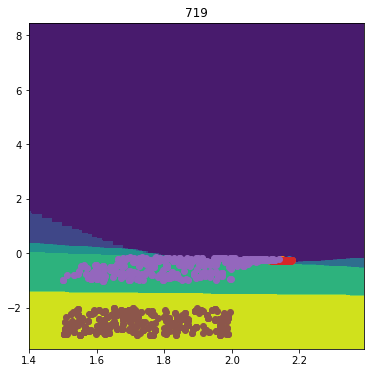

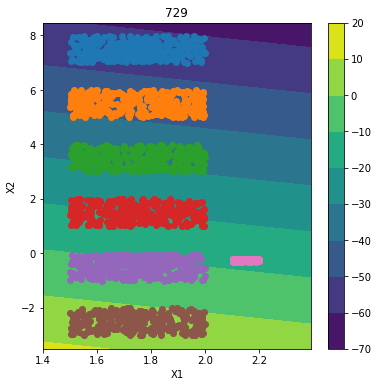

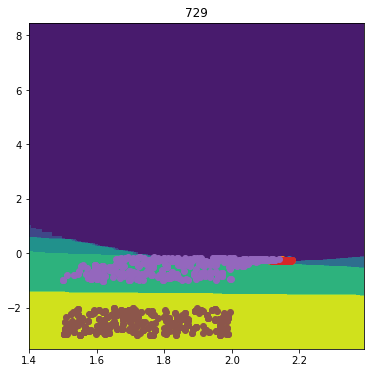

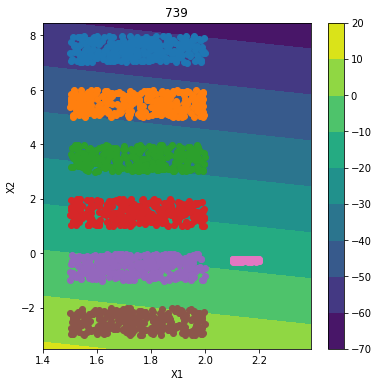

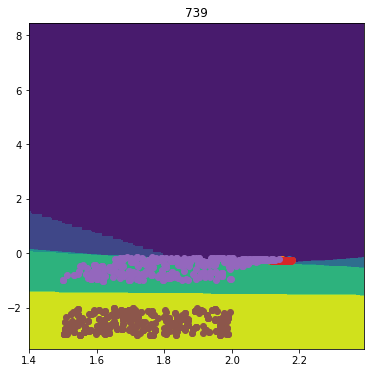

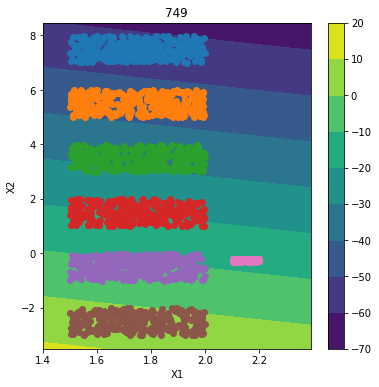

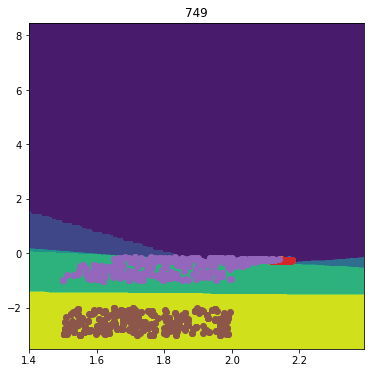

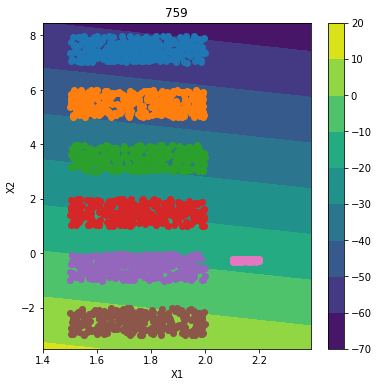

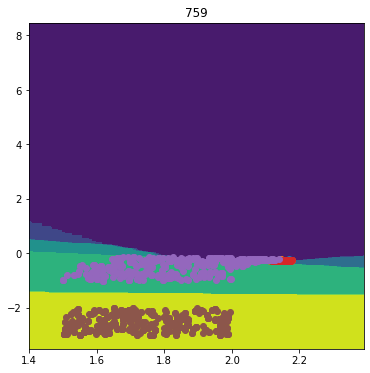

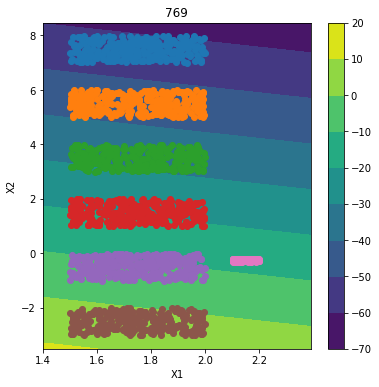

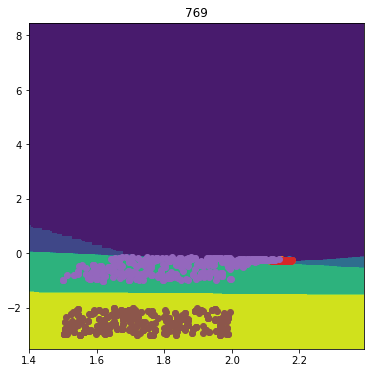

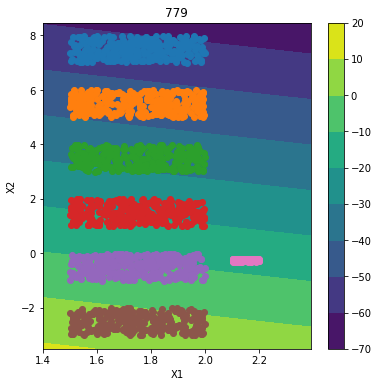

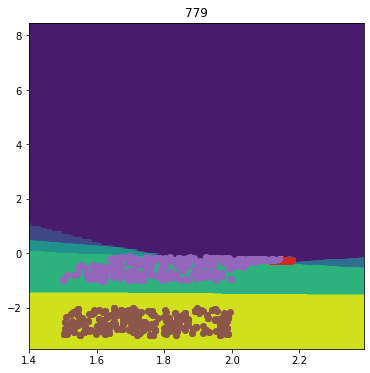

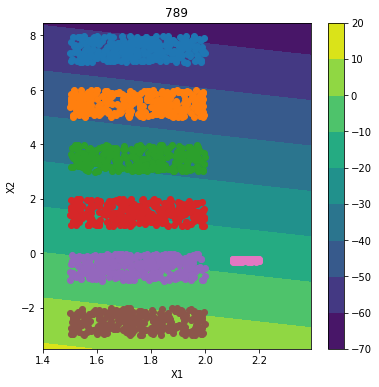

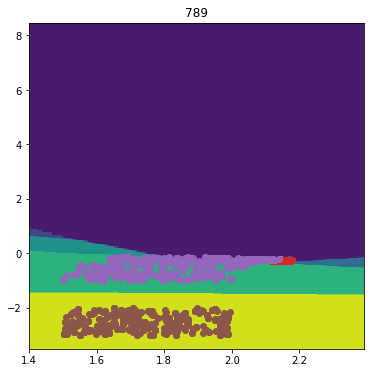

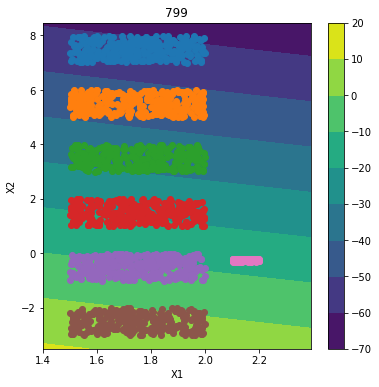

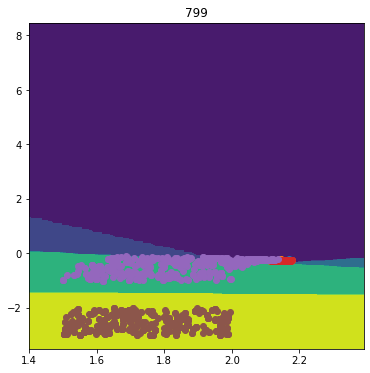

In [21]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.1)#,momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.1)#, momentum=0.9)

nos_epochs = 800
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0
        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    if (epoch+1)%10 ==0:
      plot_focus_classification_illustration(where,what,epoch)

print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


In [22]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [23]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,3000,0,496,980,1524
1,4,302,2698,493,492,461,1554
2,9,493,2507,493,515,422,1570
3,14,493,2507,495,500,411,1594
4,19,493,2507,493,502,409,1596
...,...,...,...,...,...,...,...
156,779,862,2138,848,512,127,1513
157,784,864,2136,846,513,130,1511
158,789,864,2136,849,467,127,1557
159,794,865,2135,849,510,127,1514


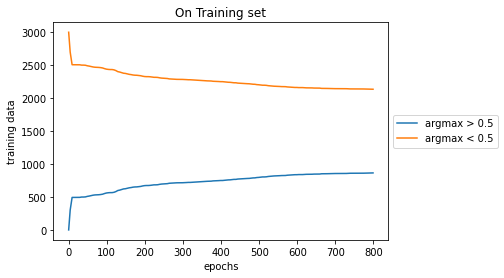

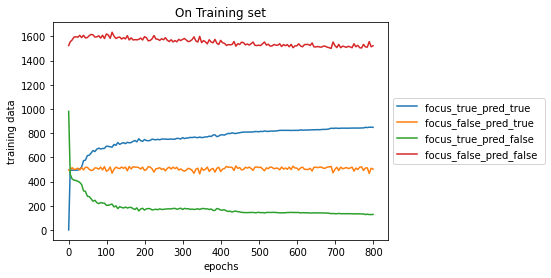

In [24]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("dist_4_train.png",bbox_inches="tight")
plt.savefig("dist_4_train.pdf",bbox_inches="tight")
plt.show()

In [25]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,0,150,329,521
1,4,146,854,176,161,150,513
2,9,176,824,176,171,135,518
3,14,176,824,176,171,134,519
4,19,176,824,176,171,132,521
...,...,...,...,...,...,...,...
156,779,298,702,294,171,34,501
157,784,298,702,296,159,32,513
158,789,298,702,295,171,33,501
159,794,298,702,296,171,32,501


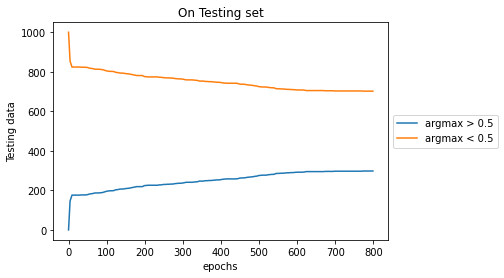

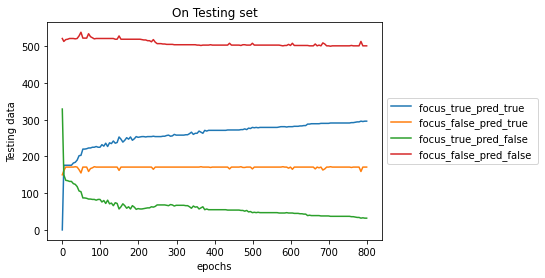

In [26]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.savefig("dist_4_test.png",bbox_inches="tight")
plt.savefig("dist_4_test.pdf",bbox_inches="tight")
plt.show()

In [27]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [28]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[-6.6734, -6.0127]], dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-0.5601], dtype=torch.float64, requires_grad=True))


In [29]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [30]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[519,   0,   0,   0,   0,   0],
       [496,   0,   0,   0,   0,   0],
       [504,   0,   0,   0,   0,   0],
       [493,   0,   0,   0,   0,   0],
       [116,  24,   0,   0, 355,   0],
       [  0,   0,   0,   0,   0, 493]])

In [32]:
sum(true==pred)/3000

0.45566666666666666